# Exploring Recommender System for AIRBNB

In this project we will create a recommender System for AirBNB. Airbnb, Inc. (/ˌɛərˌbiːɛnˈbiː/ AIR-BEE-en-BEE, an abbreviation of its original name, "Air Bed and Breakfast"[5]) is an American company operating an online marketplace for short-and-long-term homestays, experiences and services in various countries and regions. It acts as a broker and charges a commission from each booking. Airbnb was founded in 2008 by Brian Chesky, Nathan Blecharczyk, and Joe Gebbia. It is the best-known company for short-term housing rentals (Source Wikipedia)

A user is presented with a list of homes that may be similar to ones he has browsed or rated:
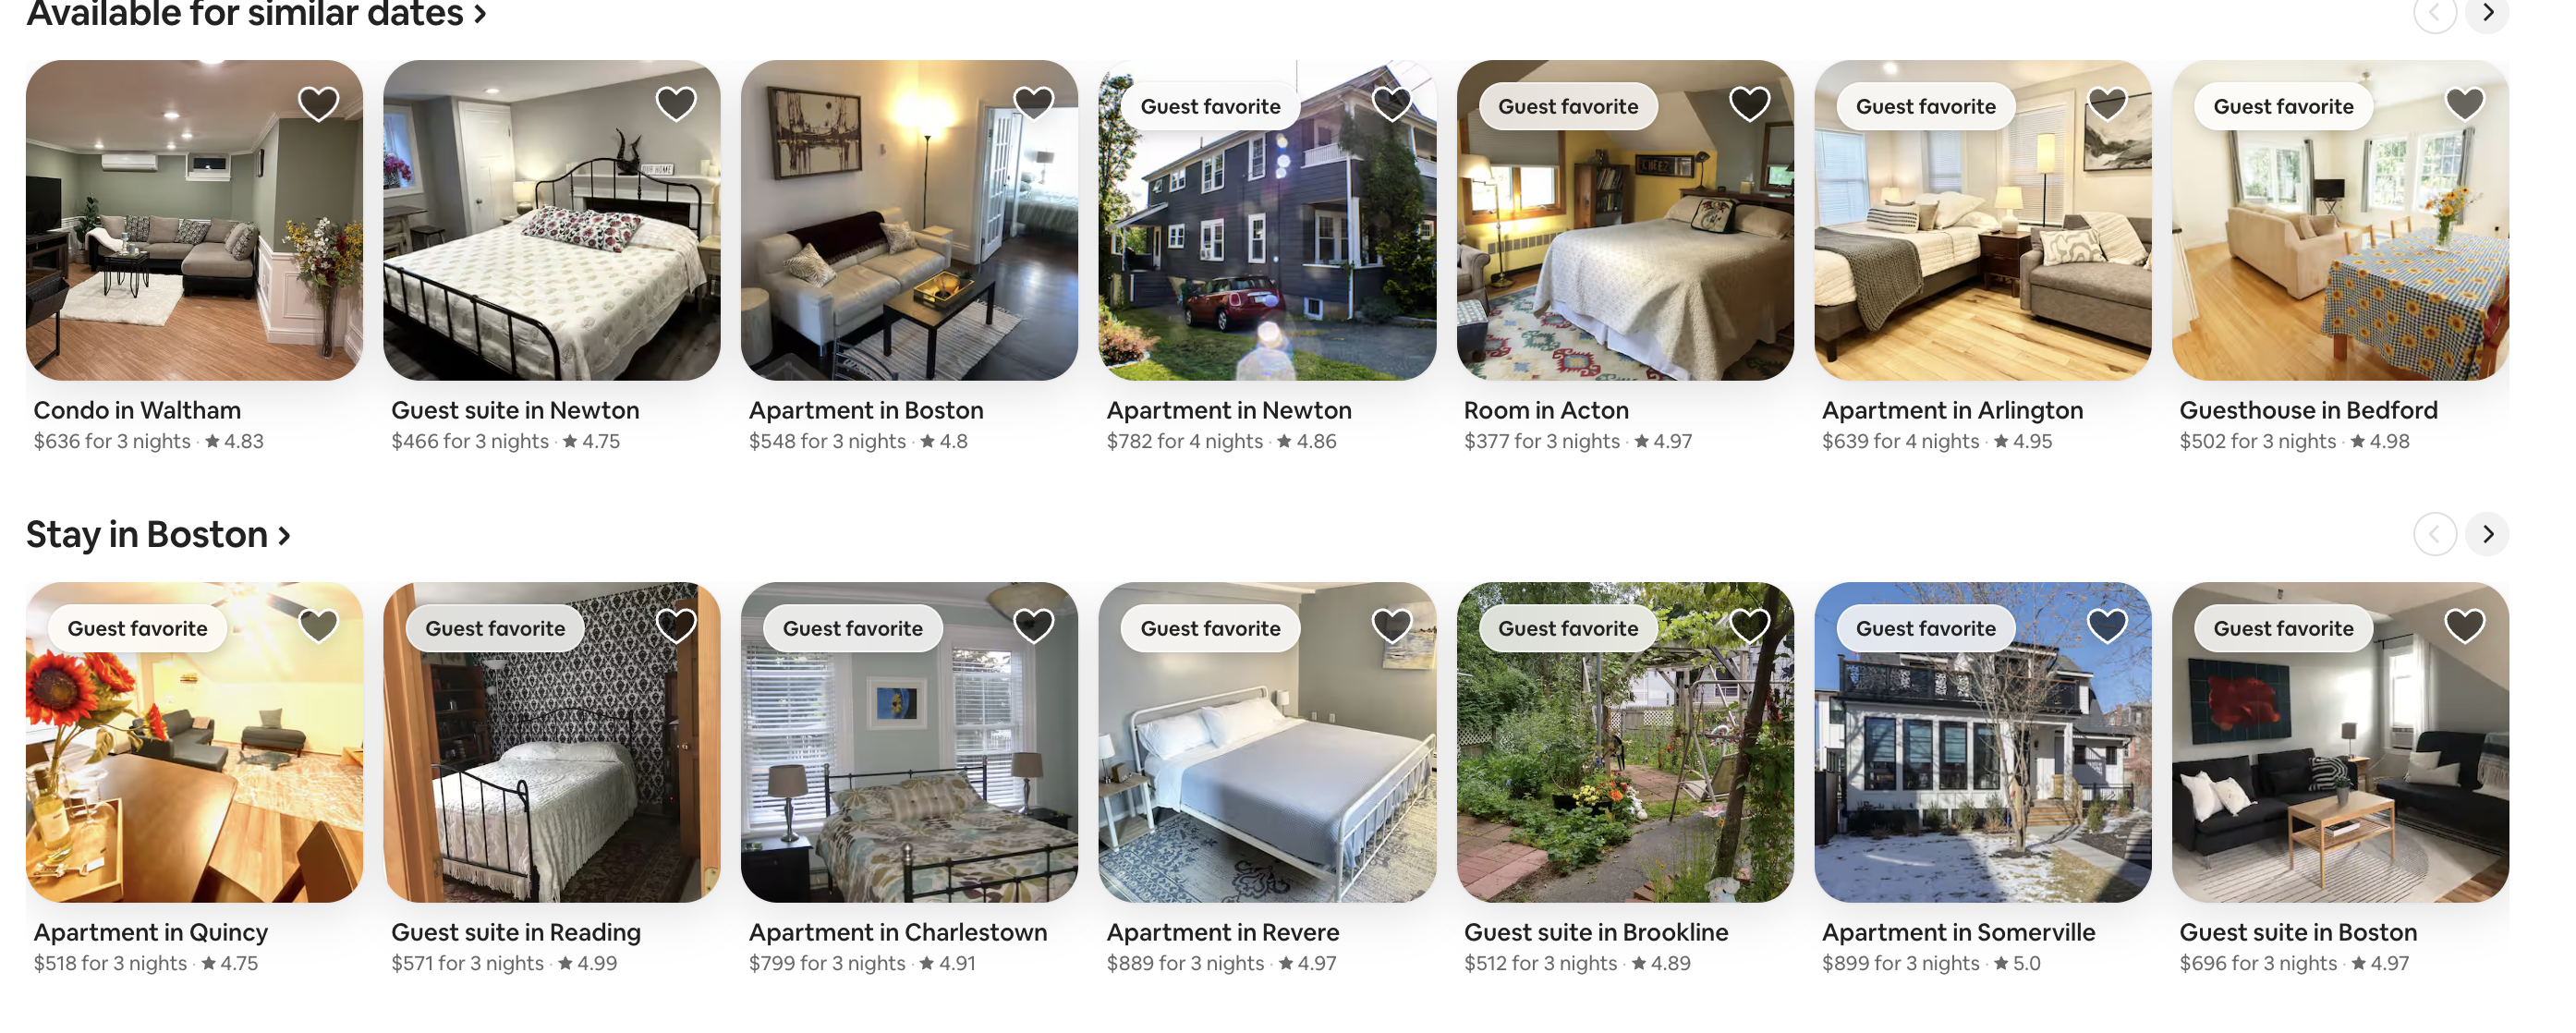

We will build a recommender system for airbnb listing using open data from kaggle: https://www.kaggle.com/datasets/airbnb/seattle

## Loading data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


# Importing the dataset
listings = pd.read_csv('./listings.csv.zip', usecols = ['id', 'name', 'description'])
listings.head(10)

id                                 name  \
0   241032         Stylish Queen Anne Apartment   
1   953595   Bright & Airy Queen Anne Apartment   
2  3308979  New Modern House-Amazing water view   
3  7421966                   Queen Anne Chateau   
4   278830       Charming craftsman 3 bdm house   
5  5956968      Private unit in a 1920s mansion   
6  1909058      Queen Anne Private Bed and Bath   
7   856550    Tiny Garden cabin on Queen Anne     
8  4948745     Urban Charm || Downtown || Views   
9  2493658   Airy + Bright Queen Anne Apartment   

                                         description  
0  Make your self at home in this charming one-be...  
1  Chemically sensitive? We've removed the irrita...  
2  New modern house built in 2013.  Spectacular s...  
3  A charming apartment that sits atop Queen Anne...  
4  Cozy family craftman house in beautiful neighb...  
5  We're renting out a small private unit of one ...  
6  Enjoy a quiet stay in our comfortable 1915 Cra...  
7  Our tiny cabin is private , very quiet and com...  
8  Nestled in the heart of the city, this space i...  
9  Beautiful apartment in an extremely safe, quie...

### Basic cleanup 
Check for nulls etc

In [2]:
listings.shape

(3818, 3)

In [3]:
listings[listings['description'].isna()]

Empty DataFrame
Columns: [id, name, description]
Index: []

In [4]:
listings[listings['name'].isna()]

Empty DataFrame
Columns: [id, name, description]
Index: []

## EDA

In [7]:
listings['counts'] = listings['description'].apply(lambda x : len(x))

In [8]:
listings.sort_values('counts', ascending=False).head(10)

id                                 name  \
0       241032         Stylish Queen Anne Apartment   
2356    741699     Seward Park Zen Retreat 苏厄德公园禅撤退   
2342   7263506     Private Mother-in-law Studio Apt   
2343   7037522      Large Studio by Lake Washington   
2344   1416763                 Lake Washington home   
2345   3726391  PLAY- 3  Kayaks  Big 3 Bedroom Home   
2346  10188794           Bright Brand New Apartment   
2348   1277033      Modern, Clean, Private Entrance   
2350   2736961       Garden Studio in Columbia City   
2352   7386675  Seward Park Bungalow (SeaFair Spot)   

                                            description  counts  
0     Make your self at home in this charming one-be...    1000  
2356  THE PLACE Light-filled home with two bedrooms ...    1000  
2342  Basement mother-in-law suite nestled between S...    1000  
2343  This lovely daylight lower level apartment (wi...    1000  
2344  View property located in one of Seattle's exce...    1000  
2345  Welcome! Nestle in my artsy, comfortable, home...    1000  
2346  One block from Lake Washington, close to Sewar...    1000  
2348  We are pleased to offer our eco-renovated gues...    1000  
2350  Seattle's most diverse neighborhood full of ar...    1000  
2352  Nestled on a quiet dead end street near local ...    1000

<Axes: >

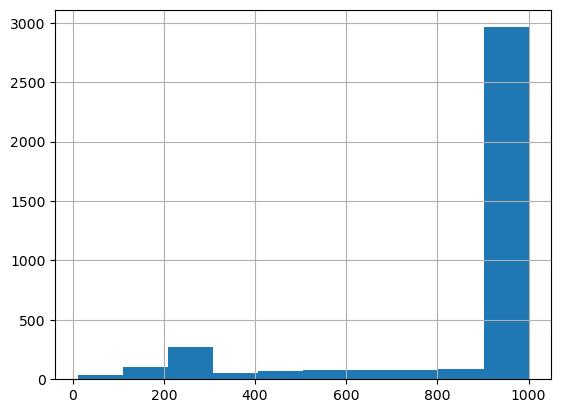

In [9]:
listings['counts'].hist()

#### Looks like most descriptions are around 1000 words and truncated at that number

We will create a word cloud for the most frequent words in this dataset.

## Word Cloud

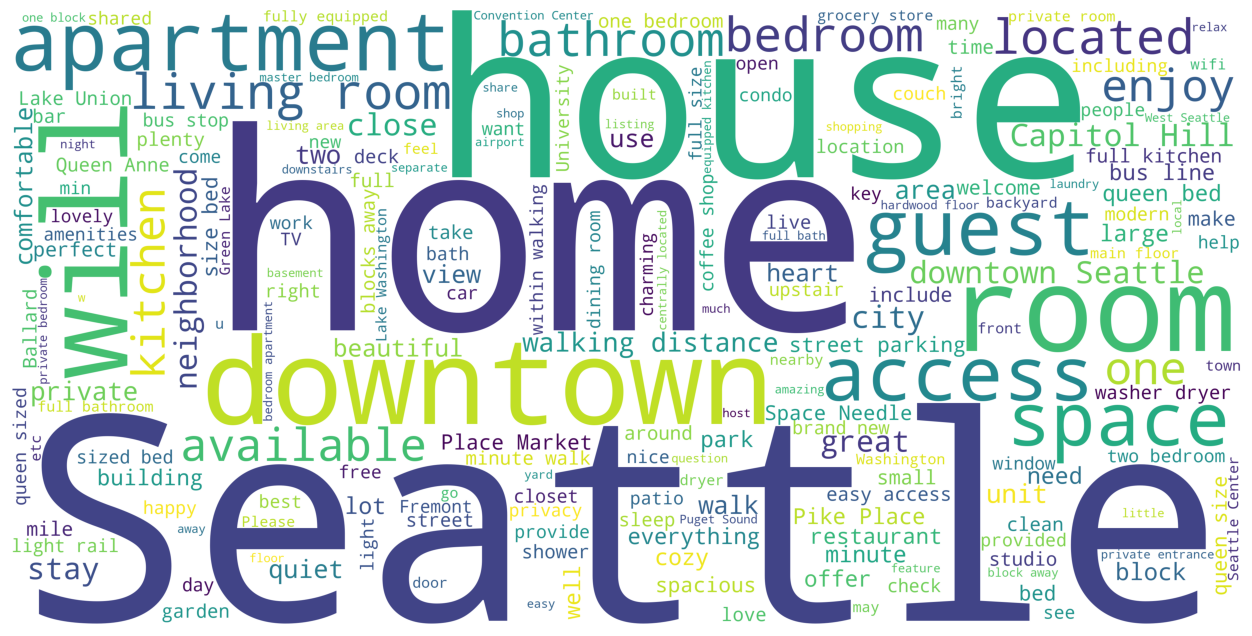

In [10]:
description_corpus = ' '.join(listings['description'])
description_wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white', height = 2000, width = 4000).generate(description_corpus)
plt.figure(figsize = (16,8))
plt.imshow(description_wordcloud)
plt.axis('off')
plt.show()


### Lets create a column that is concatenation of name and description


In [11]:
listings['content'] = listings[['name', 'description']].astype(str).apply(lambda x: ' // '.join(x), axis = 1)
listings.head()

id                                 name  \
0   241032         Stylish Queen Anne Apartment   
1   953595   Bright & Airy Queen Anne Apartment   
2  3308979  New Modern House-Amazing water view   
3  7421966                   Queen Anne Chateau   
4   278830       Charming craftsman 3 bdm house   

                                         description  counts  \
0  Make your self at home in this charming one-be...    1000   
1  Chemically sensitive? We've removed the irrita...    1000   
2  New modern house built in 2013.  Spectacular s...    1000   
3  A charming apartment that sits atop Queen Anne...     243   
4  Cozy family craftman house in beautiful neighb...    1000   

                                             content  
0  Stylish Queen Anne Apartment // Make your self...  
1  Bright & Airy Queen Anne Apartment // Chemical...  
2  New Modern House-Amazing water view // New mod...  
3  Queen Anne Chateau // A charming apartment tha...  
4  Charming craftsman 3 bdm house // Cozy family ...

### TFIDF vectorizer
We create a TFIDF vectorizer and vectorize the words in the content. a tfidf_matrix is then created which is a cosine_similarity matrix for these vectors

In [12]:
# Only create unigrams and bigrams. 
tf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 2), min_df = 0.0, stop_words = 'english')
tfidf_matrix = tf.fit_transform(listings['content'])

In [123]:
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

#### Finding properties that are similar that the user is looking at. 
Suppose the user is looking at listing with id 3308979:

  *New Modern House-Amazing water view 
  New modern house built in 2013.  Spectacular sunset/water views and light, rooftop deck and lounge area, hot tub, 5 bedrooms, gourmet kitchen.  Perfect for 2-3 families, walk to downtown.  Located in highly desirable Queen Anne neighborhood. Our house is modern, light and fresh with a warm simple palette accented with barnwood, steel and concrete.  Open living spaces for entertaining, gourmet kitchen, deck off the kitchen, reading nook, half bath and smaller tv room off kitchen.  Fireplace with sofa and sitting area. Basement room is great for kids...this room has patio access and a garage door that opens into the space with basketball hoop right outside.  A queen bedroom and full bath are in the basement with concrete heated floors.  A queen sleeper sofa is in the tv area in the basement.  This room has a door if privacy is needed.  Great for a second family with kids.  The 2nd floor has 4 bedrooms (one queen in master, one twin bedroom, another bedroom has twin bunk beds and the last*

In the code below we sort the similarity values for each id and get the top 10 most similar items

In [124]:
results = {}
# For each listing, we get the top 100 with the highest similarity score.
for idx, row in listings.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-10:-1]
    similar_items = [(cosine_similarities[idx][i], listings['id'][i]) for i in similar_indices]
    results[row['id']] = similar_items[1:]
    
print(listings[listings['id'] == 3308979]['content'])

# Similar items for listing id 3308979
for res in results[3308979][:2]:
    print(listings[listings['id'] == int(res[1])]['content'].iloc[0])

2    New Modern House-Amazing water view // New mod...
Name: content, dtype: object
VIEW-Monthly Rental Available // Our home is very light and full of character and charm.  Great gourmet kitchen and large living room with sunset views of the water.  3 bedrooms, 2.25 bath, large private garden with fountain and plenty of parking.  Located 5 minutes from downtown. Our home is a brick tudor/cottage built in 1937.  Original beveled glass windows, beautiful hardwoods and sunset water views.  Located in the desirable Queen Anne neighborhood just a few blocks from coffee shops, restaurants, grocery. This is a enchanted, open, light house with a wonderful garden, fountain, play space, large living spaces and views of the sound.  Great for 2 families with kids.  The living room is very large with views of the water, fireplace and a great space to socialize.  Large dining room with table for 6 or when extended 10 people.  There is also a library on the main floor with large couch and views of t

#### The match looks pretty close to the original listing

### Finding a match for user based on user description. 
Another application could be where the user describes the apartment they want and we find a match based on cosine similarity with the tfidf_matrix. In this instance we can't use the similarity matrix, but use the dot product to calculate similar vectors.

In [125]:
import numpy as np
def get_top_n_match(text, n, tfm):
    tf_vec = tf.transform( [text])
    #print(tf_vec.T.shape)
    #print(tfidf_matrix.shape)
    res = np.dot(tfm, tf_vec.T)
    x = res.toarray()
    map_result = {index: element[0] for index, element in enumerate(x)}
    indexes = dict(sorted(map_result.items(), key = lambda x: x[1], reverse=True)[:n])
    return listings.iloc[list(indexes.keys())]

new_content = "2 bedroom apartment near metro in quite neighborhood. Must have parking"
print(get_top_n_match(new_content, 5, tfidf_matrix)['content'].iloc[0])
print(get_top_n_match(new_content, 5, tfidf_matrix)['content'].iloc[1])


Belltown Apt near Pike's Place // Great 1 bedroom apartment near Stadium, Space Needle, Olympic Sculpture Park, and Pike's Place Market.  Just Uber Ride away from trendy Capitol Hill.  Access to rooftop.
Private room  at North Seattle // I have spare room to rent our. Private room but need share bathroom. The house locate at nice quite neighborhood. There are buses to take to downtown. There is supermarket near by. Living room, bathroom and kitchen is share. You can use any of the  cookware but clean after use.


### Using Doc2Vec 

We use Doc2Vec to create ebeddings out of the documents and create a similarity matrix



In [76]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /Users/admin/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### Tokenize the words and remove the stop words. Store it in the listings as 'cleaned'

In [107]:
common_texts = listings['content']

common_texts = [word_tokenize(sw_removed.lower()) for sw_removed in common_texts if not sw_removed in stopwords.words()]
common_texts[0][:5]
listings['cleaned'] = common_texts

In [108]:
listings.iloc[0]

id                                                        241032
name                                Stylish Queen Anne Apartment
description    Make your self at home in this charming one-be...
counts                                                      1000
content        Stylish Queen Anne Apartment // Make your self...
cleaned        [stylish, queen, anne, apartment, //, make, yo...
Name: 0, dtype: object

In [126]:
# Tagged documents are input for doc2vec model. 
tagged_data = []
for i, doc in listings.iterrows():
    tagged = TaggedDocument(doc['cleaned'], [doc['id']])
    tagged_data.append(tagged)

tagged_data[0]

TaggedDocument(words=['stylish', 'queen', 'anne', 'apartment', '//', 'make', 'your', 'self', 'at', 'home', 'in', 'this', 'charming', 'one-bedroom', 'apartment', ',', 'centrally-located', 'on', 'the', 'west', 'side', 'of', 'queen', 'anne', 'hill', '.', 'this', 'elegantly-decorated', ',', 'completely', 'private', 'apartment', '(', 'bottom', 'unit', 'of', 'a', 'duplex', ')', 'has', 'an', 'open', 'floor', 'plan', ',', 'bamboo', 'floors', ',', 'a', 'fully', 'equipped', 'kitchen', ',', 'a', 'tv', ',', 'dvd', 'player', ',', 'basic', 'cable', ',', 'and', 'a', 'very', 'cozy', 'bedroom', 'with', 'a', 'queen-size', 'bed', '.', 'the', 'unit', 'sleeps', 'up', 'to', 'four', '(', 'two', 'in', 'the', 'bedroom', 'and', 'two', 'on', 'the', 'very', 'comfortable', 'fold', 'out', 'couch', ',', 'linens', 'included', ')', 'and', 'includes', 'free', 'wifi', 'and', 'laundry', '.', 'the', 'apartment', 'opens', 'onto', 'a', 'private', 'deck', ',', 'complete', 'with', 'it', "'s", 'own', 'bbq', ',', 'overlooking',

We have the data ready. Now we can create a Doc2Vec model and start training it. It will create a model and we will add some hyperparameters. The hyperparameters are documented at https://radimrehurek.com/gensim/models/doc2vec.html. We can also save the trained model in to a file for usage later on.

In [127]:
import multiprocessing
max_epochs = 100
vec_size = 100
alpha = 0.025

cores = multiprocessing.cpu_count()

model = Doc2Vec(vector_size=vec_size,
               alpha=alpha, 
               min_alpha=0.00025,
               min_count=1,
               dm=1,
               workers = cores-1)

model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration{0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    
    # Decrease the learning rate
    model.alpha -= 0.0002
    
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("listings.model")
print("Model Saved")

iteration0
iteration1
iteration2
iteration3
iteration4
iteration5
iteration6
iteration7
iteration8
iteration9
iteration10
iteration11
iteration12
iteration13
iteration14
iteration15
iteration16
iteration17
iteration18
iteration19
iteration20
iteration21
iteration22
iteration23
iteration24
iteration25
iteration26
iteration27
iteration28
iteration29
iteration30
iteration31
iteration32
iteration33
iteration34
iteration35
iteration36
iteration37
iteration38
iteration39
iteration40
iteration41
iteration42
iteration43
iteration44
iteration45
iteration46
iteration47
iteration48
iteration49
iteration50
iteration51
iteration52
iteration53
iteration54
iteration55
iteration56
iteration57
iteration58
iteration59
iteration60
iteration61
iteration62
iteration63
iteration64
iteration65
iteration66
iteration67
iteration68
iteration69
iteration70
iteration71
iteration72
iteration73
iteration74
iteration75
iteration76
iteration77
iteration78
iteration79
iteration80
iteration81
iteration82
iteration83
it

In [117]:
model = Doc2Vec.load("./listings.model")

# Create new sentence and vectorize it. 
new_sentence = new_content.split(" ")
new_sentence_vectorized = model.infer_vector(new_sentence)

# Calculate cosine similarity. 
similar_sentences = model.docvecs.most_similar(positive=[new_sentence_vectorized])

#### We get the ids for similar sentenses to the new_sentense. 

In [118]:
similar_sentences

[(7311407, 0.505403459072113),
 (8741711, 0.5000137090682983),
 (7318378, 0.4856926202774048),
 (7384645, 0.4841679036617279),
 (1159618, 0.4819919168949127),
 (1786923, 0.4791514277458191),
 (931154, 0.4739784598350525),
 (580843, 0.46836239099502563),
 (4210585, 0.46789780259132385),
 (6332584, 0.46775197982788086)]

In [122]:
ids = [ x[0] for x in similar_sentences]
listings[listings['id'].isin(ids)]['content']


769     Interns-New available Walk to UW 41 // It has ...
1333    Met Tower in Belltown! MT2 // The Metropolitan...
1358    Best Condo Near Pike Place! MT2 // The Metropo...
1461    5 Star Location! Parking, WIFI S4 // Stay down...
2938    Capitol Hill Apartment // Open one bedroom clo...
Name: content, dtype: object

In [134]:
# Lets look at the matched ids in detail
listings[listings['id']==4210585]['content'].iloc[0]

"Best Condo Near Pike Place! MT2 // The Metropolitan Tower property is centrally located on Westlake Avenue, between 6th and 7th. This unit features 2 Bedrooms, 2 Bathrooms, Kitchen, Washer/Dryer, and Sleeps 6.                AMAZING BUILDING, AMENITIES, AND LOCATION WITH A VIEW!!! The Property Who says you can't have it all? This amazing property is located in one of Seattle's best neighborhoods and is only a few blocks from the legendary Pike's Place market and walking distance to many of Seattle's hot spots. Walk over to Safeco Field and Seahawks Stadium, visit the hottest restaurants and bars or take the monorail to Seattle Center and Key arena. Don't worry, you won't navigate living in this gem of a property alone, you will have access to one of our amazing concierges. Perfect Location Our business travelers will enjoy Metro's prime location. The property is situated near UPS and FedEx with many car rental companies located a few minutes away from our vacation rental. Of course, t

## Evaluation

For recommender systems like these, we don't have a objective measure for evaluation. We have to rely on human subjects to look at the sentenses and check if the recommendations make sense.
